In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch

This data is CGM values in mg/dl and is in 15 minute increments. Each row is a new patient (97) and each column is a reading. Each patient has 480 readings or 5 days of data 

In [75]:
df.shape

(97, 480)

In [76]:
df = pd.read_csv("cgm_data.csv").sample(frac=1)
for column in df.columns:
    df[column] = df[column].astype(float)
df.rename({0:"ID"}, axis=1)
df = df.drop("ptid",axis=1)

In [77]:
class LSTMPredictor(torch.nn.Module):
    def __init__(self,n_hidden=51, device='cpu'):
        super(LSTMPredictor, self).__init__()
        self.n_hidden = n_hidden
        # lstm1, lstm2, linear
        self.lstm1 = torch.nn.LSTMCell(1,self.n_hidden)
        self.lstm2 = torch.nn.LSTMCell(self.n_hidden,self.n_hidden)
        self.linear = torch.nn.Linear(self.n_hidden,1)
    
    def forward(self,x,future=0):
        # N, 100
        outputs = []
        n_samples = x.size(0)
        h_t = torch.zeros(n_samples, self.n_hidden, dtype = torch.float32)
        c_t = torch.zeros(n_samples, self.n_hidden, dtype = torch.float32)
        
        
        h_t2 = torch.zeros(n_samples, self.n_hidden, dtype = torch.float32)
        c_t2 = torch.zeros(n_samples, self.n_hidden, dtype = torch.float32)
        
        for input_t in x.split(1, dim=1):
            #N, 1
            h_t, c_t = self.lstm1(input_t, (h_t,c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2,c_t2))
            output = self.linear(h_t2)
            outputs.append(output)
        
        for i in range(future):
            h_t, c_t = self.lstm1(output, (h_t,c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2,c_t2))
            output = self.linear(h_t2)
            outputs.append(output)
            
        outputs = torch.cat(outputs,dim=1)
        return outputs

In [78]:
train_input = torch.from_numpy(df.iloc[1:90,:-1].values).float()
train_target = torch.from_numpy(df.iloc[1:90,1:].values).float()
test_input = torch.from_numpy(df.iloc[90:91,:-1].values).float()
test_target = torch.from_numpy(df.iloc[90:91,1:].values).float()

In [82]:
model = LSTMPredictor()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
n_steps = 1000

Step 0
loss 23767.53125
test loss 20203.400390625
loss 20203.400390625
Step 10
loss 21878.4453125
test loss 18451.42578125
loss 18451.42578125
Step 20
loss 20418.341796875
test loss 17063.224609375
loss 17063.224609375
Step 30
loss 18997.779296875
test loss 15713.52734375
loss 15713.52734375
Step 40
loss 17656.251953125
test loss 14446.60546875
loss 14446.60546875
Step 50
loss 16405.8828125
test loss 13269.369140625
loss 13269.369140625
Step 60
loss 15246.2978515625
test loss 12180.5517578125
loss 12180.5517578125
Step 70
loss 14172.12890625
test loss 11174.650390625
loss 11174.650390625
Step 80
loss 13177.373046875
test loss 10245.7587890625
loss 10245.7587890625
Step 90
loss 12256.4931640625
test loss 9388.48828125
loss 9388.48828125
Step 100
loss 11404.58203125
test loss 8598.04296875
loss 8598.04296875
Step 110
loss 10617.2626953125
test loss 7870.1298828125
loss 7870.1298828125
Step 120
loss 9890.5634765625
test loss 7200.84130859375
loss 7200.84130859375
Step 130
loss 9220.809570

IndexError: index 1 is out of bounds for dimension 0 with size 1

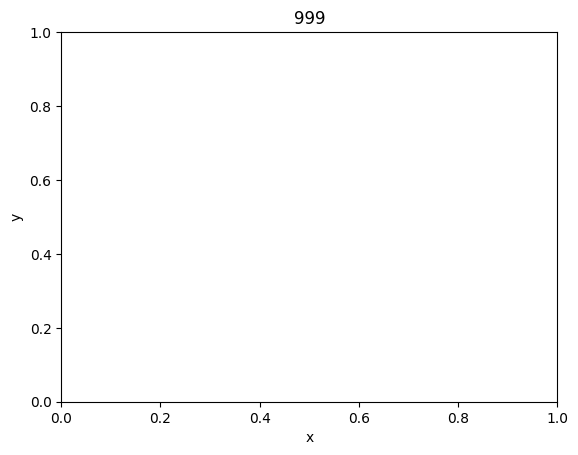

In [83]:
for i in range(n_steps):
    optimizer.zero_grad()
    out = model(train_input)
    loss = criterion(out,train_target)
    if not i%10:
        print("Step",i)
        print("loss", loss.item())
    loss.backward()

    optimizer.step()
    
    with torch.no_grad():
        future= 100
        pred = model(test_input, future = future)
        loss = criterion(pred[:,:-future], test_target)
        if not i%10:
            print("test loss", loss.item())
            print("loss", loss.item())
        y = pred.detach().numpy()
    
    
def draw(true, pred, index, color):
    plt.figure()
    plt.title(i)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xticks()
    plt.yticks()
    n = train_input.shape[1]
    plt.plot(np.arange(n), true[index,:], color)
    plt.plot(np.arange(n+future), y[index,:], color + ":")
    plt.show()
draw(test_input, test_target,1,'r')


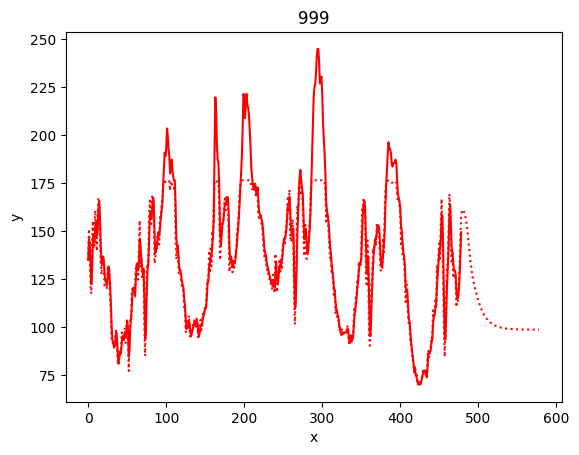

In [84]:
draw(test_input, test_target,0,'r')
